In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Fungsi untuk memuat label dari file .idx1-ubyte.gz
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

# Fungsi untuk memuat gambar dari file .idx3-ubyte.gz
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16)
        images = images.reshape(-1, 28*28) / 255.0  # Normalisasi piksel ke rentang [0, 1]
    return images

train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')
train_images = load_mnist_images('train-images-idx3-ubyte.gz')

Memuat isi file dataset MNIST ke dalam variabel "train_labels" dan "train_images"

In [3]:
indices = np.where((train_labels == 0) | (train_labels == 1))
train_images = train_images[indices]
train_labels = train_labels[indices]

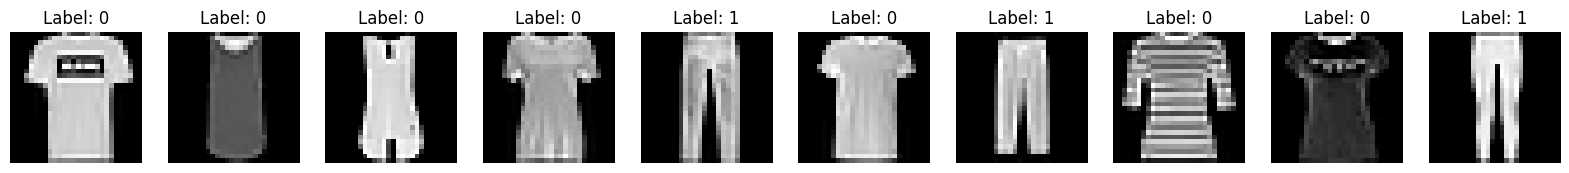

In [4]:
# Contoh: Menampilkan beberapa gambar dengan labelnya
n = 10  # Jumlah gambar yang ditampilkan
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Split data menjadi train, validation, and test
X_train, X_test, _, _ = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
X_train, X_val, _, _ = train_test_split(X_train, train_labels[:len(X_train)], test_size=0.1, random_state=42)

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

# Decoder
x = Dense(6272, activation='relu')(encoded)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

kode diatas bertujuan untuk mengubah dimensi MNIST dari bentuk 1D (784 piksel) menjadi bentuk 2D (28x28 piksel). Serta mempersiapkan data untuk dimasukkan ke dalam Autoencoder dan mengkonfigurasi model untuk pelatihan.

In [8]:
# ringkasan model
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

Tabel diatas memberikan gambaran tentang struktur dan detail implementasi dari model neural network yang Anda jelaskan.

In [9]:
# Training Autoencoder
autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True, validation_data=(X_val, X_val))

# Prediksi dan evaluasi dengan SSIM pada data test
decoded_imgs = autoencoder.predict(X_test)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0768 - val_loss: 0.0206
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0184 - val_loss: 0.0129
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0054 - val_loss: 0.0052
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [10]:
from skimage.metrics import structural_similarity as ssim

# Menghitung SSIM
ssim_scores = []
for i in range(len(X_test)):
    score = ssim(X_test[i].reshape(28, 28), decoded_imgs[i].reshape(28, 28), data_range=1.0)
    ssim_scores.append(score)

# Menghitung rata-rata SSIM
mean_ssim = np.mean(ssim_scores)
print(f"Mean SSIM: {mean_ssim:.4f}")

Mean SSIM: 0.8532


Hasil ini menunjukkan bahwa model diatas memiliki performa yang baik dalam melakukan rekonstruksi MNIST

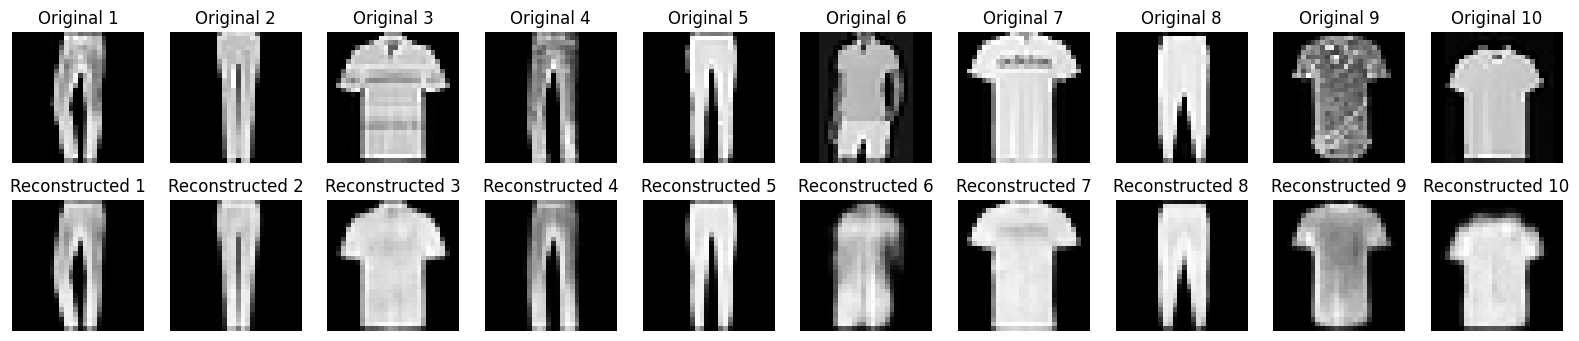

In [11]:
# Visualisasi beberapa contoh hasil rekonstruksi
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # gambar asli
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    # gambar rekonstruksi
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title(f'Reconstructed {i+1}')
    plt.axis('off')
plt.show()

In [12]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [13]:
# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Menampilkan ringkasan arsitektur model
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim

# Training Autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train, epochs=20, batch_size=128, shuffle=True,
                          validation_data=(X_val, X_val), callbacks=[early_stopping])

# Prediksi dan evaluasi dengan SSIM pada data test
decoded_imgs = autoencoder.predict(X_test)

def calculate_mean_ssim(original_imgs, decoded_imgs):
    ssim_values = []
    for i in range(len(original_imgs)):
        ssim_value = ssim(original_imgs[i].reshape(28, 28), decoded_imgs[i].reshape(28, 28), data_range=1)
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

mean_ssim = calculate_mean_ssim(X_test, decoded_imgs)
print(f"Mean SSIM: {mean_ssim:.4f}")

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.4434 - val_loss: 0.3025
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.2925 - val_loss: 0.2729
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.2719 - val_loss: 0.2631
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.2624 - val_loss: 0.2577
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2593 - val_loss: 0.2548
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.2569 - val_loss: 0.2528
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.2563 - val_loss: 0.2511
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.2517 - val_loss: 0.2497
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2505 - val_loss: 0.2486
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2512 - val_loss: 0.2485
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2511 - val_loss: 0.2471
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.2

### penjelasan
- Batch Normalization: Menambahkan Batch Normalization pada setiap layer konvolusi membantu dalam mempercepat konvergensi dan meningkatkan stabilitas model selama pelatihan.

- Adam Optimizer: Menggunakan Adam Optimizer mengoptimalkan proses pelatihan dengan memanfaatkan momentum dan learning rate adaptif, menghasilkan konvergensi yang lebih cepat dan stabil.

- Early Stopping: Penerapan Early Stopping dengan val_loss memungkinkan model untuk berhenti pelatihan saat performa tidak meningkat, mencegah overfitting dan menghasilkan model yang lebih umum.

- Penyesuaian Shape Data: Memastikan shape data yang benar pada proses rekonstruksi gambar menjaga kompatibilitas antara input dan output model, penting untuk konsistensi dan keakuratan rekonstruksi.

- Peningkatan Mean SSIM: Hasil evaluasi menunjukkan peningkatan Mean SSIM, menandakan bahwa model mampu merekonstruksi gambar dengan lebih baik, mendekati kualitas gambar asli.

### Klasifikasi jenis pakaian pada dataset gambar

In [29]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')

In [30]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential

num_classes = 10

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Layer output untuk multi-class classification
])

In [ ]:
# Compile model dengan loss and optimizer untuk multi-class classification
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7942 - loss: 0.6443 - val_accuracy: 0.9854 - val_loss: 0.0430
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9855 - loss: 0.0432 - val_accuracy: 0.9917 - val_loss: 0.0274
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9902 - loss: 0.0297 - val_accuracy: 0.9896 - val_loss: 0.0300
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.9925 - val_loss: 0.0214
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9917 - loss: 0.0240 - val_accuracy: 0.9925 - val_loss: 0.0212
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9958 - val_loss: 0.0180
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9944 - loss: 0.0155 - val_accuracy: 0.9942 - val_loss: 0.0202
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9954 - loss: 0.0154 - val_accuracy: 0.9942 - v

In [34]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0147
Test accuracy: 0.9958


In [35]:
sample_images = X_test[:num_classes]
sample_labels = y_test[:num_classes]

In [36]:
# Buat prediksi untuk gambar-gambar ini
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)  # Ambil label dengan probabilitas tertinggi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


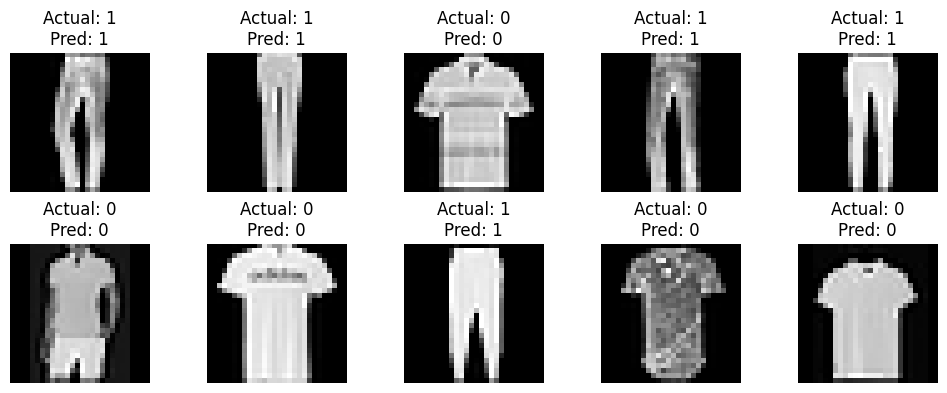

In [43]:
# Plot hasil
plt.figure(figsize=(10, 4))
for i in range(num_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    actual_label = sample_labels[i]
    predicted_label = predicted_labels[i]
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
plt.tight_layout()
plt.show()